# Data-efficient Image Transforme

## Import Library

In [2]:
import os
import time
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingLR

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [4]:
BATCH_SIZE = 32
IMG_SIZE = 224
VAL_SPLIT = 0.2
NUM_EPOCHS = 20
MODEL_NAME_FOLDER = "DeiT-Tiny"
OUTPUT_DIR = os.path.join("/content/drive/MyDrive/DeepLearningTiny", MODEL_NAME_FOLDER)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Load & Preparation Data

In [5]:
# Transform
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

class_names = train_dataset.classes
num_classes = len(class_names)
class_names

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
num_train = int((1 - VAL_SPLIT) * len(train_dataset))
num_val = len(train_dataset) - num_train

train_dataset, val_dataset = random_split(train_dataset, [num_train, num_val])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataset), len(val_dataset), len(test_dataset)

(40000, 10000, 10000)

## Load DeiT Tiny (Pretrained)

In [7]:
MODEL_NAME = "deit_tiny_patch16_224"

model = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=num_classes
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [8]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params
model_size_mb = (total_params * 4) / (1024**2)  # float32

print("=== PARAMETER INFO ===")
print(f"Total Parameters     : {total_params:,}")
print(f"Trainable Parameters : {trainable_params:,}")
print(f"Non-trainable Params : {non_trainable_params:,}")
print(f"Model Size (MB)      : {model_size_mb:.2f} MB")

=== PARAMETER INFO ===
Total Parameters     : 5,526,346
Trainable Parameters : 5,526,346
Non-trainable Params : 0
Model Size (MB)      : 21.08 MB


In [9]:
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes)

# Freeze backbone
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
best_wts = copy.deepcopy(model.state_dict())
best_acc = 0

## Training + Validation Loop

In [11]:
for epoch in range(NUM_EPOCHS):

    model.train()
    train_loss, train_correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = train_correct / total
    train_loss /= len(train_loader)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            _, preds = outputs.max(1)

            val_loss += loss.item()
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss /= len(val_loader)

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))

    scheduler.step()

Epoch 1/20 | Train Acc: 0.88 | Val Acc: 0.90
Epoch 2/20 | Train Acc: 0.90 | Val Acc: 0.90
Epoch 3/20 | Train Acc: 0.90 | Val Acc: 0.90
Epoch 4/20 | Train Acc: 0.90 | Val Acc: 0.89
Epoch 5/20 | Train Acc: 0.90 | Val Acc: 0.90
Epoch 6/20 | Train Acc: 0.90 | Val Acc: 0.90
Epoch 7/20 | Train Acc: 0.90 | Val Acc: 0.90
Epoch 8/20 | Train Acc: 0.90 | Val Acc: 0.90
Epoch 9/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 10/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 11/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 12/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 13/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 14/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 15/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 16/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 17/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 18/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 19/20 | Train Acc: 0.91 | Val Acc: 0.90
Epoch 20/20 | Train Acc: 0.91 | Val Acc: 0.90


In [12]:
model.load_state_dict(best_wts)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


## Classification Report

In [13]:
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n=== TEST ACCURACY ===")
print(np.mean(np.array(y_true) == np.array(y_pred)))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


=== TEST ACCURACY ===
0.905

Classification Report:
              precision    recall  f1-score   support

    airplane       0.91      0.92      0.91      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.91      0.87      0.89      1000
         cat       0.84      0.82      0.83      1000
        deer       0.88      0.90      0.89      1000
         dog       0.87      0.87      0.87      1000
        frog       0.92      0.94      0.93      1000
       horse       0.90      0.91      0.91      1000
        ship       0.94      0.93      0.94      1000
       truck       0.93      0.94      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.90      0.91      0.90     10000
weighted avg       0.90      0.91      0.90     10000



In [14]:
df_pred = pd.DataFrame({
    "true": [class_names[i] for i in y_true],
    "pred": [class_names[i] for i in y_pred]
})

df_pred.to_csv(os.path.join(OUTPUT_DIR, "predictions.csv"), index=False)

SAMPLE_DIR = os.path.join(OUTPUT_DIR, "samples")
os.makedirs(SAMPLE_DIR, exist_ok=True)

## Confusion Matrix

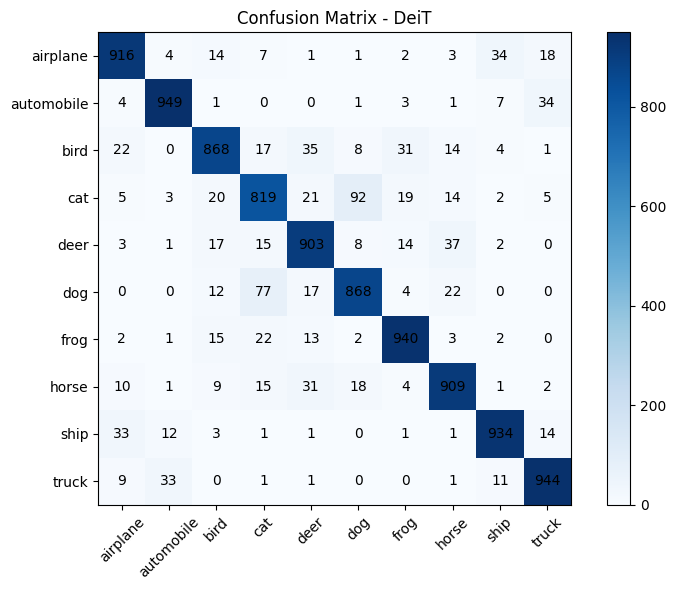

In [15]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - DeiT")

plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"), dpi=300)
plt.show()
plt.close('all')


## Learning Curves (Loss & Accuracy)

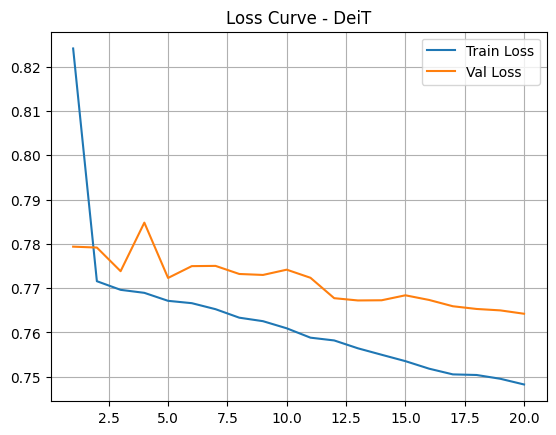

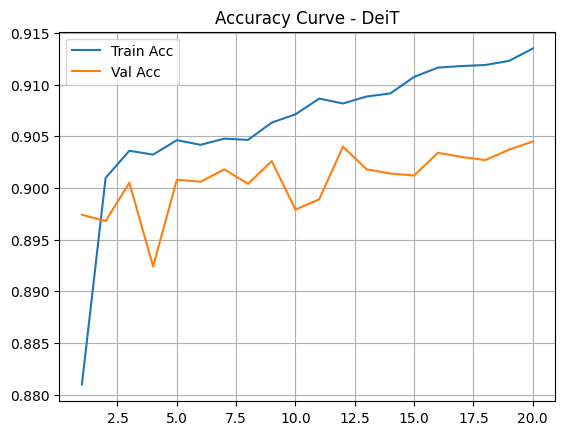

In [22]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.title("Loss Curve - DeiT")
plt.legend()
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, "loss_curve.png"), dpi=300)
plt.show()
plt.close('all')

plt.figure()
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.title("Accuracy Curve - DeiT")
plt.legend()
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, "acc_curve.png"), dpi=300)
plt.show()
plt.close('all')



In [17]:
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n=== TEST ACCURACY ===")
print(np.mean(np.array(y_true) == np.array(y_pred)))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


=== TEST ACCURACY ===
0.905

Classification Report:
              precision    recall  f1-score   support

    airplane       0.91      0.92      0.91      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.91      0.87      0.89      1000
         cat       0.84      0.82      0.83      1000
        deer       0.88      0.90      0.89      1000
         dog       0.87      0.87      0.87      1000
        frog       0.92      0.94      0.93      1000
       horse       0.90      0.91      0.91      1000
        ship       0.94      0.93      0.94      1000
       truck       0.93      0.94      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.90      0.91      0.90     10000
weighted avg       0.90      0.91      0.90     10000



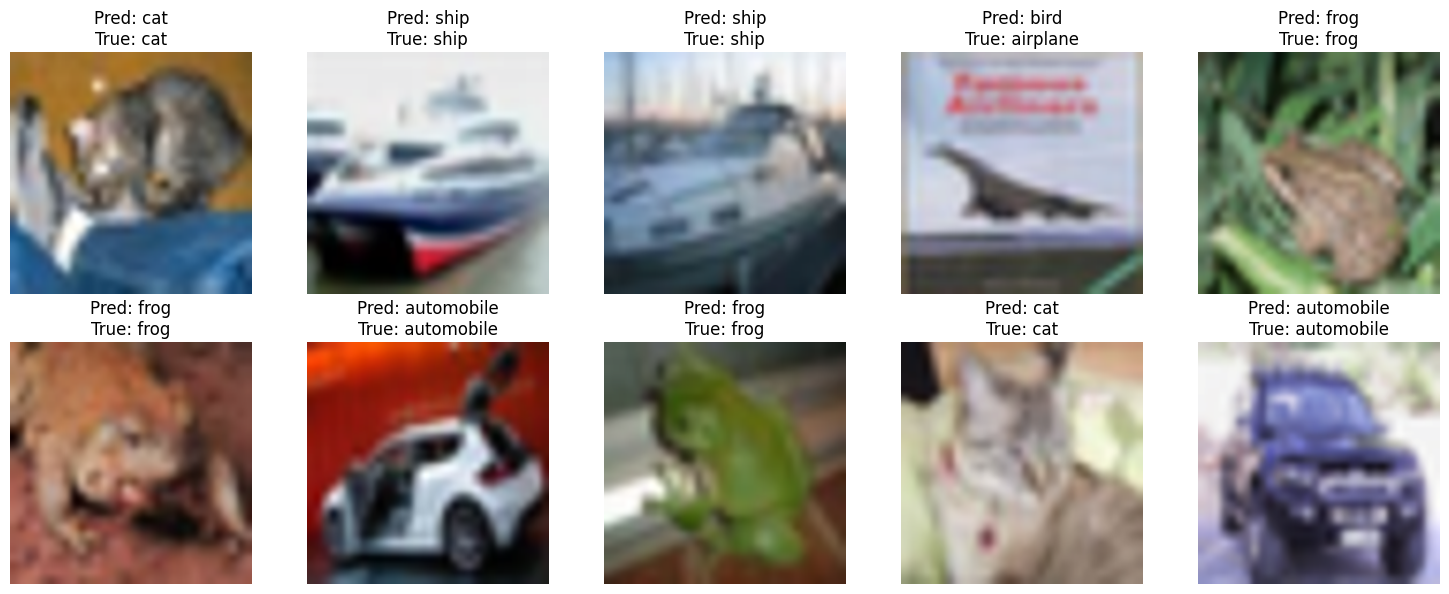

In [20]:
model.eval()

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# tampilkan 10 sample
dataiter = iter(test_loader)
images, labels = next(dataiter)

images_gpu = images.to(device)
labels_gpu = labels.to(device)

with torch.no_grad():
    outputs = model(images_gpu)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    imshow(images_gpu[i].cpu())
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels_gpu[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "sample_predictions.png"), dpi=300)
plt.show()
plt.close('all')

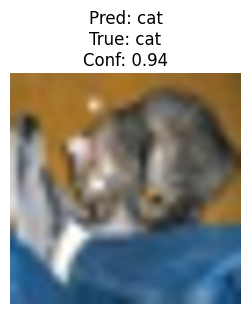

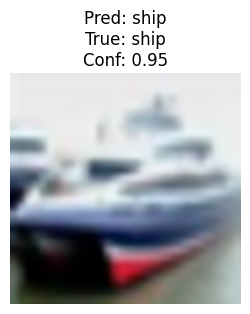

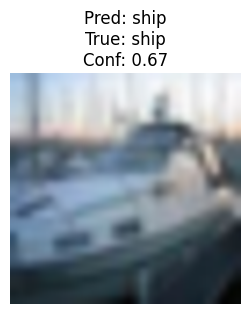

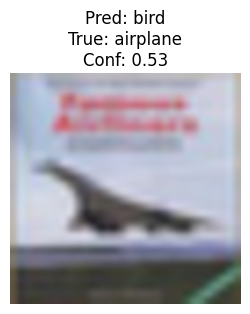

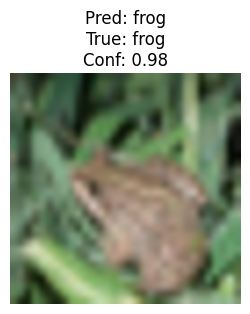

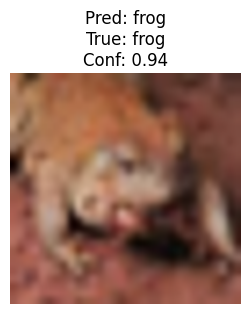

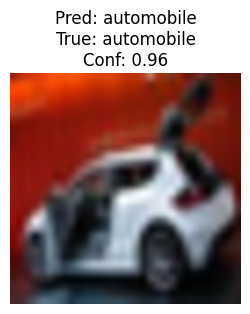

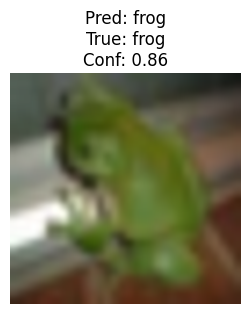

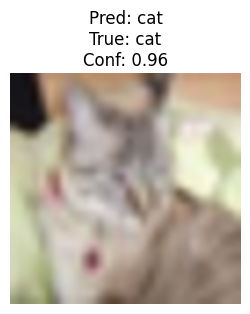

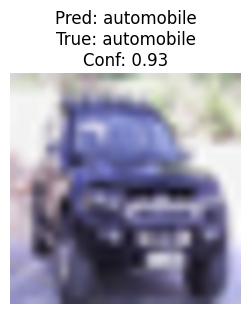

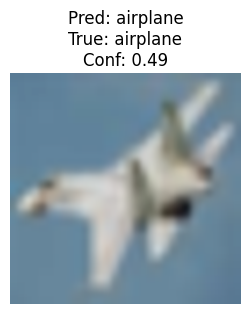

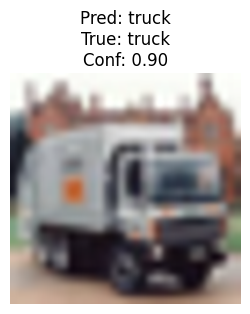

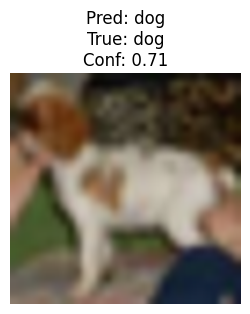

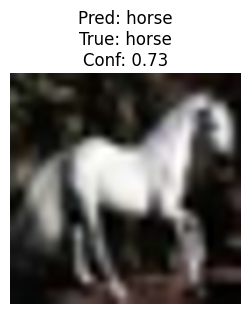

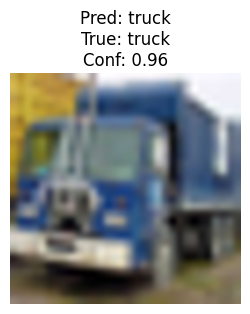

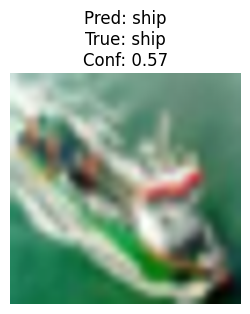

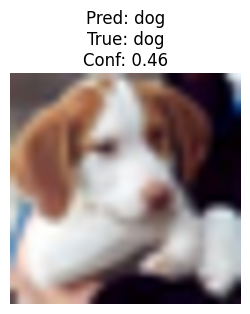

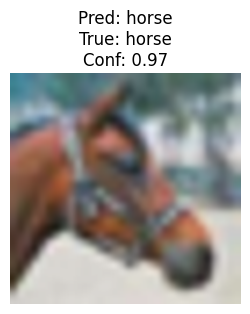

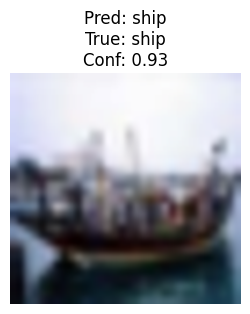

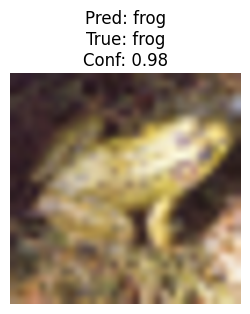

In [21]:
SAMPLE_DIR = os.path.join(OUTPUT_DIR, "samples")
os.makedirs(SAMPLE_DIR, exist_ok=True)

model.eval()
sample_saved = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        probs = torch.softmax(outputs, dim=1)
        confs, preds = probs.max(1)

        for i in range(images.size(0)):

            img = images[i].detach().cpu()
            img = img.numpy().transpose(1,2,0)
            img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
            img = np.clip(img,0,1)

            plt.figure(figsize=(3,3))
            plt.imshow(img)
            plt.title(
                f"Pred: {class_names[preds[i].item()]}\n"
                f"True: {class_names[labels[i].item()]}\n"
                f"Conf: {confs[i].item():.2f}"
            )
            plt.axis('off')

            plt.savefig(os.path.join(SAMPLE_DIR, f"sample_{sample_saved}.png"))
            plt.show()
            plt.close()

            sample_saved += 1
            if sample_saved >= 20:
                break
        if sample_saved >= 20:
            break